# **Importação das Bibliotecas**

In [1]:
from typing import Tuple
from datetime import datetime

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

# **Definição das funções**

In [3]:
def plot_pie_chart(df: pl.DataFrame, var: str, title: str, pctdistance: float=0.6, 
                   labeldistance: float=1.1, figsize: Tuple[int]=(8,6)) -> None:
    """Plot a pie chart.

    Args:
        df (pl.DataFrame): DataFrame with the data.
        var (str): DataFrame column/variable.
        title (str): Chart title.
        pctdistance (float, optional): The relative distance along the radius 
        at which the text generated by autopct is drawn. To draw the text outside 
        the pie, set pctdistance > 1. Defaults to 0.6.
        labeldistance (float, optional): The relative distance along the radius at 
        which the labels are drawn. To draw the labels inside the pie, set 
        labeldistance < 1. Defaults to 1.1.
        figsize (Tuple[int], optional): Tuple with figure size. Defaults to (8,6).
    """
    
    df_value_counts = df[var].value_counts(sort=True)

    data = df_value_counts["count"].to_numpy()
    labels = df_value_counts[var].to_numpy()

    colors = sns.color_palette("bright", len(labels))

    plt.figure(figsize=figsize)
    plt.pie(x=data, labels=labels, autopct="%.2f%%", pctdistance=pctdistance, 
            labeldistance=labeldistance, colors=colors)
    plt.title(title)
    plt.show()

In [4]:
def plot_bar_chart(df: pl.DataFrame, var: str, ylabel: str, 
                   title: str, figsize: Tuple[int]=(8,6)) -> None:
    """Plot a bar chart.

    Args:
        df (pl.DataFrame): DataFrame with the data.
        var (str): DataFrame column/variable.
        ylabel (str): y axis name.
        title (str): Chart title.
        figsize (Tuple[int], optional): Tuple with figure size. Defaults to (8,6).
    """
    
    df_value_counts = df[var].value_counts(sort=True)

    data = df_value_counts["count"].to_numpy()
    labels = df_value_counts[var].to_numpy()

    colors = sns.color_palette("bright", len(labels))

    plt.figure(figsize=figsize)
    ax = sns.barplot(x=data, y=labels, hue=labels, palette=colors)
    plt.xlabel("Contagem")
    plt.ylabel(ylabel)
    plt.title(title)

    for i, v in enumerate(data):
        ax.text(v + 0.1, i, v, va="center")
        
    plt.show()

# **Base de Dados 1: Store Item Demand**

## **Leitura dos Dados**

In [5]:
store_item_demand = pl.read_csv("../data/01_raw/STORE_ITEM/STORE_ITEM_DEMAND.csv")
store_item_demand.head(5)

date,store,item,sales
str,i64,i64,i64
"""2013-01-01""",1,1,13
"""2013-01-02""",1,1,11
"""2013-01-03""",1,1,14
"""2013-01-04""",1,1,13
"""2013-01-05""",1,1,10


## **Análise Inicial**

- ***date:*** Data das vendas.
- ***store:*** ID exclusivo da loja.
- ***item:*** ID exclusivo do item.
- ***sales:*** Contagem de vendas.

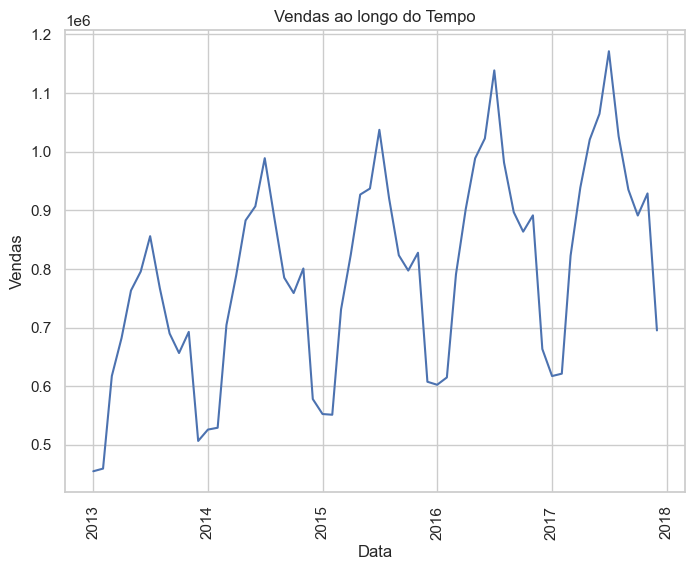

In [6]:
# Agregação para demanda mensal (para melhorar a visualização do gráfico)
agg_df = (
        store_item_demand.with_columns(pl.col("date").str.to_datetime()).group_by_dynamic(
            index_column="date", 
            every="1mo",
            closed="left", 
            group_by=["store", "item"],
            include_boundaries=False
        )
        .agg(
            [
                pl.sum("sales")
            ]
        )
    )

agg = agg_df.group_by("date", maintain_order=True).agg(pl.sum("sales"))

plt.figure(figsize=(8,6))
sns.lineplot(x="date", y="sales", data=agg)
plt.title("Vendas ao longo do Tempo")
plt.xlabel("Data")
plt.xticks(rotation=90)
plt.ylabel("Vendas")
plt.show()

In [7]:
store_item_demand.describe()

statistic,date,store,item,sales
str,str,f64,f64,f64
"""count""","""913000""",913000.0,913000.0,913000.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,5.5,25.5,52.250287
"""std""",null,2.872283,14.430878,28.801144
"""min""","""2013-01-01""",1.0,1.0,0.0
"""25%""",null,3.0,13.0,30.0
"""50%""",null,6.0,26.0,47.0
"""75%""",null,8.0,38.0,70.0
"""max""","""2017-12-31""",10.0,50.0,231.0


 - A base de dados possui 913.000 registros;
- Nehuma série possui valores faltantes (NaN);
- Nenhuma série possui demanda negativa ou algum valor absurdo que precise ser tratado;
- Data mínima: 01/01/2013; Data máxima: 31/12/2017.

### **Séries, registros e datas**

In [8]:
gb_store_item_demand = store_item_demand.group_by(["store", "item"]).len().sort(by="len")

start = datetime.strptime(store_item_demand["date"].min(), "%Y-%m-%d")
end = datetime.strptime(store_item_demand["date"].max(), "%Y-%m-%d")
all_dates = pl.datetime_range(start=start, end=end, interval="1d", eager=True).alias("date")

equal_dates = 0
for store in store_item_demand["store"].unique().to_list():
    for item in store_item_demand["item"].unique().to_list():
        store_item_data = store_item_demand.filter(
            (pl.col("store") == store) & (pl.col("item") == item)
        )
        if (all_dates == store_item_data["date"].str.to_datetime().sort()).all():
            equal_dates += 1

if equal_dates == gb_store_item_demand.shape[0]:
    print("Todas as séries temporais possuem a mesma quantidade de dados e as mesmas datas.")
else:
    print("As séries temporais não possuem a mesma quantidade de dados e/ou as mesmas datas.")

Todas as séries temporais possuem a mesma quantidade de dados e as mesmas datas.


In [9]:
print(f"Quantidade de séries temporais (combinações store_item): {gb_store_item_demand.shape[0]}")
print(f"Quantidade de registros (diários) por série: {gb_store_item_demand['len'][0]} (~ {int(gb_store_item_demand['len'][0] / 365)} anos)")

Quantidade de séries temporais (combinações store_item): 500
Quantidade de registros (diários) por série: 1826 (~ 5 anos)


- A base de dados possui 500 séries temporais, formadas pela combinação de 10 *stores* e *50 items*;
- Todas as séries possuem quantidade de registros e datas iguais, sem faltar nenhum dia (1826 - aproximadamente 5 anos - registros por série).

### **Agregação em semanas**

In [10]:
agg_df = (
    store_item_demand.with_columns(pl.col("date").str.to_datetime()).group_by_dynamic(
        index_column="date", 
        every="1w",
        closed="left", 
        group_by=["store", "item"],
        include_boundaries=False
    )
    .agg(
        [
            pl.sum("sales"),
        ]
    )
)

agg_df = agg_df.with_columns(
    (pl.col("date") + pl.duration(days=6)).alias("date")  # Necessário para transformar em pd.Series com frequência semanal
)

agg_df.head(5)

store,item,date,sales
i64,i64,datetime[μs],i64
1,1,2013-01-06 00:00:00,73
1,1,2013-01-13 00:00:00,66
1,1,2013-01-20 00:00:00,80
1,1,2013-01-27 00:00:00,70
1,1,2013-02-03 00:00:00,86


- Serão realizadas predições tanto para as séries com frequência diária quanto para as séries agregadas em frequência semanal, permitindo a comparação de desempenhos e resultados da mesma base com frequências diferentes.

### **Demandas intermitentes**

#### **Dados diários**

In [11]:
store_item_demand.filter(pl.col("sales") == 0)

date,store,item,sales
str,i64,i64,i64
"""2014-01-15""",6,4,0


In [12]:
daily_data = store_item_demand.group_by(["store", "item"]).agg(
    pl.col("sales").mean().alias("sales_mean"),
    pl.col("sales").std().alias("sales_std"),
)

daily_data = daily_data.with_columns(
    (pl.col("sales_std") / pl.col("sales_mean")).alias("coef_of_variation")
)

daily_data.sort("coef_of_variation")

store,item,sales_mean,sales_std,coef_of_variation
i64,i64,f64,f64,f64
8,15,108.047645,28.265443,0.261602
3,28,100.143483,26.219792,0.261822
2,28,112.638007,29.526526,0.262136
2,38,103.249179,27.084663,0.262323
8,13,103.819825,27.257209,0.262543
…,…,…,…,…
6,41,16.607338,5.902563,0.355419
7,27,15.213582,5.478561,0.36011
5,5,14.086528,5.157271,0.366114


- A base possui apenas 1 registro com demanda igual a 0;
- Os valores mínimo e máximo do coeficiente de variação das demandas não são extremamente altos, descartando a necessidade do uso de algum modelo para demandas intermintentes.

#### **Dados semanais (agregados)**

In [13]:
agg_df.filter(pl.col("sales") == 0)

store,item,date,sales
i64,i64,datetime[μs],i64


In [14]:
weekly_data = agg_df.group_by(["store", "item"]).agg(
    pl.col("sales").mean().alias("sales_mean"),
    pl.col("sales").std().alias("sales_std"),
)

weekly_data = weekly_data.with_columns(
    (pl.col("sales_std") / pl.col("sales_mean")).alias("coef_of_variation")
)

weekly_data.sort("coef_of_variation")

store,item,sales_mean,sales_std,coef_of_variation
i64,i64,f64,f64,f64
3,35,522.076628,108.48464,0.207794
2,43,460.245211,95.680484,0.20789
10,29,547.363985,114.379705,0.208965
9,2,432.310345,90.365452,0.209029
4,22,592.114943,123.801866,0.209084
…,…,…,…,…
7,27,106.436782,25.161494,0.236398
6,27,117.601533,27.895999,0.237208
9,1,163.191571,38.743259,0.23741


In [15]:
print("Média do Coeficiente de Variação dos dados:")
print(f"    Semanais: {weekly_data['coef_of_variation'].mean():.2%}")
print(f"     Diários: {daily_data['coef_of_variation'].mean():.2%}")

Média do Coeficiente de Variação dos dados:
    Semanais: 21.81%
     Diários: 29.05%


- A base possui apenas 1 registro com demanda igual a 0;
- Os valores mínimo e máximo do coeficiente de variação das demandas não são extremamente altos, descartando a necessidade do uso de algum modelo para demandas intermintentes;
- A média dos coeficientes de variação dos dados semanais é menor que a dos dados diários, ou seja, a agregação diminuiu esse valor.

## **Conclusões**

 - A base de dados possui 913.000 registros, dividos entre 500 séries temporais, formadas pela combinação de 10 *stores* e 50 *items*;
- Nehuma série possui valores faltantes (NaN);
- Nenhuma série possui demanda negativa ou algum valor absurdo que precise ser tratado; 
- Todas as séries possuem quantidade de registros e datas iguais (de "01/01/2013" até "31/12/2017"), sem faltar nenhum dia (1826 - aproximadamente 5 anos - registros por série);
- De acordo com a quantidade de demandas igual a 0 e os valores mínimo e máximo do coeficiente de variação das demandas, não será necessário o uso de um modelo para demandas intermitentes;
- Serão realizadas predições tanto para as séries com frequência diária quanto para as séries agregadas em frequência semanal, permitindo a comparação de desempenhos e resultados da mesma base com frequências diferentes.

# **Base de Dados 2: Food Demand**

## **Leitura dos Dados**

In [16]:
food_demand = pl.read_csv(f"../data/01_raw/FOOD/FOOD_DEMAND.csv")
food_demand.head(5)

id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
i64,i64,i64,i64,f64,f64,i64,i64,i64
1379560,1,55,1885,136.83,152.29,0,0,177
1466964,1,55,1993,136.83,135.83,0,0,270
1346989,1,55,2539,134.86,135.86,0,0,189
1338232,1,55,2139,339.5,437.53,0,0,54
1448490,1,55,2631,243.5,242.5,0,0,40


In [17]:
meal_info = pl.read_csv("../data/01_raw/FOOD/MEAL_INFO.csv")
meal_info.head(5)

meal_id,category,cuisine
i64,str,str
1885,"""Beverages""","""Thai"""
1993,"""Beverages""","""Thai"""
2539,"""Beverages""","""Thai"""
1248,"""Beverages""","""Indian"""
2631,"""Beverages""","""Indian"""


In [18]:
fulfilment_center_info = pl.read_csv("../data/01_raw/FOOD/FULFILMENT_CENTER_INFO.csv")
fulfilment_center_info.head(5)

center_id,city_code,region_code,center_type,op_area
i64,i64,i64,str,f64
11,679,56,"""TYPE_A""",3.7
13,590,56,"""TYPE_B""",6.7
124,590,56,"""TYPE_C""",4.0
66,648,34,"""TYPE_A""",4.1
94,632,34,"""TYPE_C""",3.6


## **Análise Inicial**

### **Informações do centro de distribuição**

- ***center_id:*** ID exclusivo do centro de distribuição.
- ***city_code:*** Código exclusivo para cidade.
- ***region_code:*** Código exclusivo para região.
- ***center_type:*** Tipo de centro anonimizado.
- ***op_area:*** Área de operação (em $\displaystyle {km^2}$).

In [19]:
fulfilment_center_info.describe()

statistic,center_id,city_code,region_code,center_type,op_area
str,f64,f64,f64,str,f64
"""count""",77.0,77.0,77.0,"""77""",77.0
"""null_count""",0.0,0.0,0.0,"""0""",0.0
"""mean""",83.142857,600.662338,56.493506,null,3.985714
"""std""",46.090219,66.720274,18.126473,null,1.106406
"""min""",10.0,456.0,23.0,"""TYPE_A""",0.9
"""25%""",50.0,553.0,34.0,null,3.5
"""50%""",77.0,596.0,56.0,null,3.9
"""75%""",110.0,651.0,77.0,null,4.4
"""max""",186.0,713.0,93.0,"""TYPE_C""",7.0


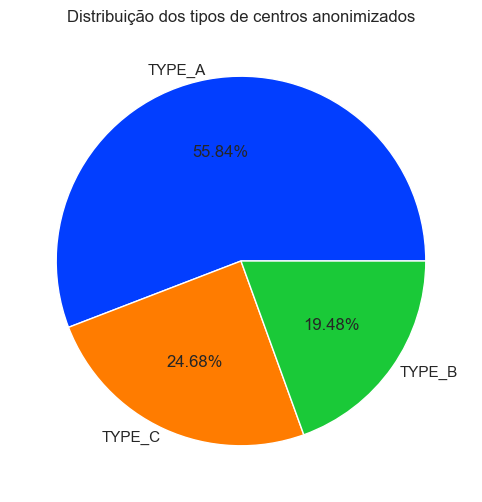

In [20]:
plot_pie_chart(df=fulfilment_center_info, var="center_type", labeldistance=1.05,
               title="Distribuição dos tipos de centros anonimizados")

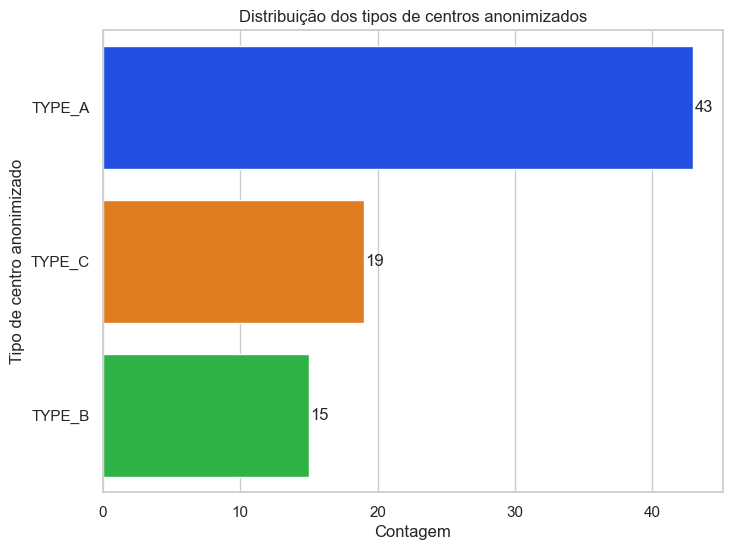

In [21]:
plot_bar_chart(df=fulfilment_center_info, var="center_type", 
               ylabel="Tipo de centro anonimizado",
               title="Distribuição dos tipos de centros anonimizados")

### **Informações sobre refeições**

- ***meal_id:*** ID exclusivo da refeição.
- ***category:*** Tipo de refeição (bebidas[beverages]/lanches[snacks]/sopas[soups]/…).
- ***cuisine:*** Culinária das refeições (indiana[Indian]/italiana[Italian]/…).

In [22]:
meal_info.describe()

statistic,meal_id,category,cuisine
str,f64,str,str
"""count""",51.0,"""51""","""51"""
"""null_count""",0.0,"""0""","""0"""
"""mean""",2013.921569,null,null
"""std""",553.633555,null,null
"""min""",1062.0,"""Beverages""","""Continental"""
"""25%""",1558.0,null,null
"""50%""",1971.0,null,null
"""75%""",2539.0,null,null
"""max""",2956.0,"""Starters""","""Thai"""


#### **Category (categoria)**

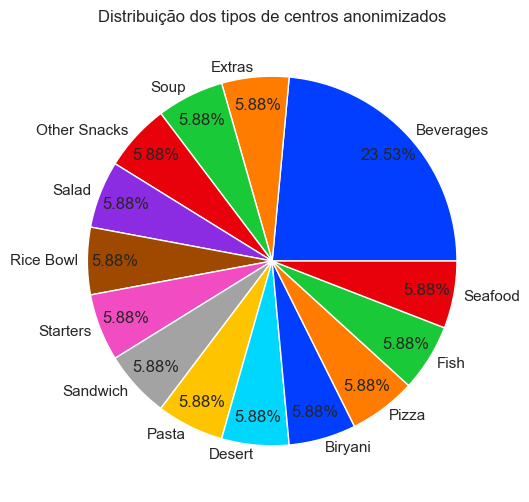

In [23]:
plot_pie_chart(df=meal_info, var="category", pctdistance=0.85, labeldistance=1.05,
               title="Distribuição dos tipos de centros anonimizados")

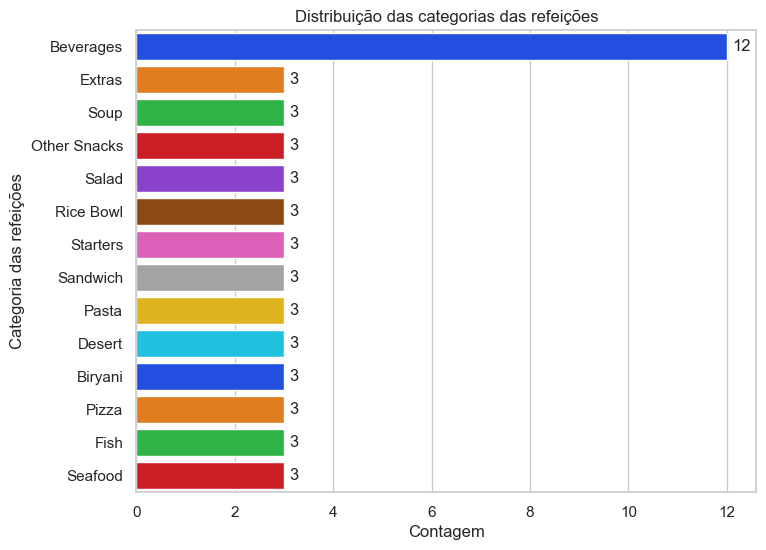

In [24]:
plot_bar_chart(df=meal_info, var="category", 
               ylabel="Categoria das refeições",
               title="Distribuição das categorias das refeições")

#### **Cuisine (culinária)**

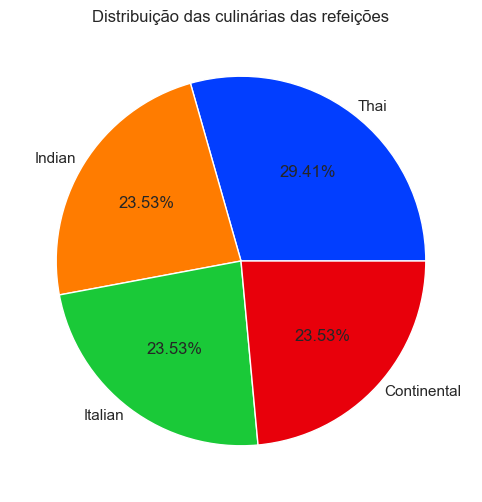

In [25]:
plot_pie_chart(df=meal_info, var="cuisine", labeldistance=1.05,
               title="Distribuição das culinárias das refeições")

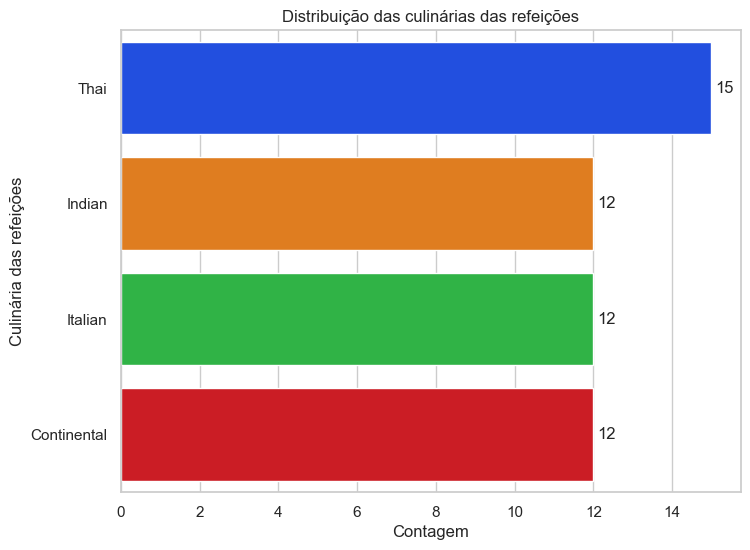

In [26]:
plot_bar_chart(df=meal_info, var="cuisine", 
               ylabel="Culinária das refeições",
               title="Distribuição das culinárias das refeições")

### **Demanda alimentar**

- ***id:*** ID exclusivo.
- ***week:*** Número da semana.
- ***center_id:*** ID exclusivo do centro de distribuição.
- ***meal_id:*** ID exclusivo da refeição.
- ***checkout_price:*** Preço final incluindo desconto, impostos e taxas de entrega.
- ***base_price:*** Preço base da refeição.
- ***emailer_for_promotion:*** Emailer enviado para promoção de refeição.
- ***homepage_featured:*** Refeição apresentada na página inicial.
- ***num_orders:*** Contagem de pedidos (alvo).

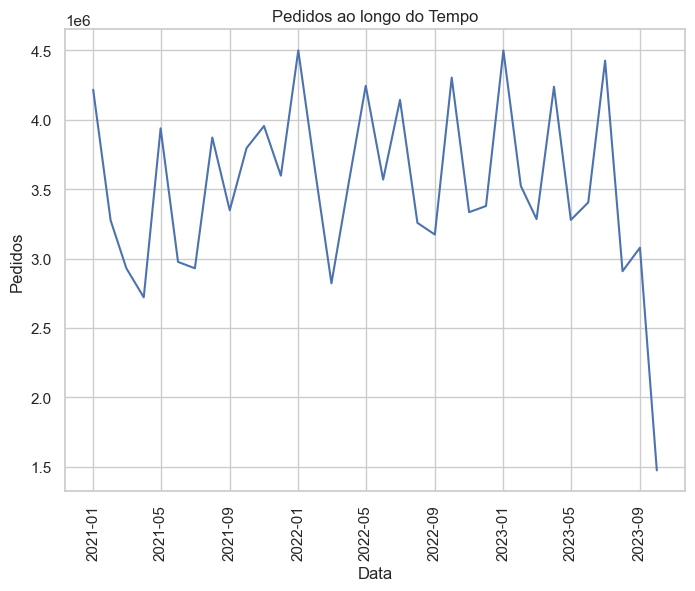

In [27]:
# Criação de datas fictícias
initial_date = pl.datetime(year=2021, month=1, day=3)
dates = initial_date + (food_demand["week"] - 1) * pl.duration(weeks=1)
food_demand_fic_dates = food_demand.with_columns(fictitious_date=dates.cast(pl.Datetime))

# Agregação para demanda mensal
agg_df = (
        food_demand_fic_dates.group_by_dynamic(
            index_column="fictitious_date", 
            every="1mo",
            closed="left", 
            group_by=["center_id", "meal_id"],
            include_boundaries=False
        )
        .agg(
            [
                pl.sum("num_orders")
            ]
        )
    )

# Agrupamento das datas e agregação das demandas por data
agg = agg_df.group_by("fictitious_date", maintain_order=True).agg(pl.sum("num_orders"))

# Criação do gráfico de linhas representando a demanda ao longo do tempo
plt.figure(figsize=(8,6))
sns.lineplot(x="fictitious_date", y="num_orders", data=agg)
plt.title("Pedidos ao longo do Tempo")
plt.xlabel("Data")
plt.xticks(rotation=90)
plt.ylabel("Pedidos")
plt.show()

In [28]:
food_demand.describe()

statistic,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",456548.0,456548.0,456548.0,456548.0,456548.0,456548.0,456548.0,456548.0,456548.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.2501e6,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.1092,261.87276
"""std""",144354.822378,41.524956,45.975046,547.42092,152.939723,160.715914,0.273069,0.31189,395.922798
"""min""",1e6,1.0,10.0,1062.0,2.97,55.35,0.0,0.0,13.0
"""25%""",1.124999e6,39.0,43.0,1558.0,228.95,243.5,0.0,0.0,54.0
"""50%""",1.250184e6,76.0,76.0,1993.0,296.82,310.46,0.0,0.0,136.0
"""75%""",1.37514e6,111.0,110.0,2539.0,445.23,458.87,0.0,0.0,324.0
"""max""",1.499999e6,145.0,186.0,2956.0,866.27,866.27,1.0,1.0,24299.0


- O conjunto de dados bruto contém 456.548 registros de demanda semanal, distribuídos entre 77 "center_id" e 51 "meal_id";
- Nenhuma série (combinação center_id x meal_id) possui demanda negativa ou algum valor absurdo que precise ser tratado (os outliers são devidos aos feriados, portanto não devem ser excluídos);
- Nehuma série possui valores nulos.

#### **Quantidade de séries temporais**

In [29]:
amount_of_series = food_demand.group_by(["center_id", "meal_id"]).len().sort("len")
amount_of_series

center_id,meal_id,len
i64,i64,u32
145,1571,1
145,2104,1
101,1571,1
24,1248,3
97,2956,3
…,…,…
65,1885,145
109,1754,145
50,1062,145


- Esse conjunto de dados possui 3.597 séries temporais, com as menores tendo 1 registro e as maiores 145 registros;
- Será usada validação cruzada do tipo ExpandingWindow com 4 Folds, onde o test_size e o step_size serão de 4 semanas;
- Serão testadas sazonalidades de 4 a 52 semanas, de 4 em 4 (onde: 4 = mensal, ..., 52 = anual);
- Para alguns modelos, é necessário ter no mínimo o dobro de registros da sazonalidade usada (2*52 = 104);
- A seguir, será calculada a quantidade mínima de semanas para alcançar os requisitos acima: 
    - initial_window = min_series_length - (test_size + ((folds - 1)*step_length)) -> Fórmula para calcular o tamanho da janela inicial (train_size do primeiro fold)
    - 104 = min_series_length - (4 + ((4 - 1)*4))
    - min_series_length = 104 + (4 + ((4 - 1)*4))
    - min_series_length = 120
- Portanto, só podem ser usadas as séries que contém 120 semanas. Isso será tratado durante o pré-processamento dos dados, onde serão adicionadas todas as semanas ausentes, com demanda igual a 0, das séries que contém menos que 145 registros. Devido a esse pré-processamento, não serão utilizadas nenhuma das outras variáveis além de: "week", "center_id", "meal_id", "num_orders".

### **Demandas intermitentes**

In [30]:
food_demand.filter(pl.col("num_orders") == 0)

id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
i64,i64,i64,i64,f64,f64,i64,i64,i64


- Nos dados brutos não existe nenhuma demanda igual a 0, pois as semanas que não venderam não existem no conjunto de dados.

In [31]:
grouped_data = food_demand.group_by(["center_id", "meal_id"], maintain_order=True).agg(
    pl.col("num_orders").mean().alias("num_orders_mean"),
    pl.col("num_orders").std().alias("num_orders_std"),
)

grouped_data = grouped_data.with_columns(
    (pl.col("num_orders_std") / pl.col("num_orders_mean")).alias("num_orders_std/mean")
)

grouped_data.sort("num_orders_std/mean")

center_id,meal_id,num_orders_mean,num_orders_std,num_orders_std/mean
i64,i64,f64,f64,f64
101,1571,14.0,null,null
145,2104,68.0,null,null
145,1571,42.0,null,null
92,2577,14.333333,0.57735,0.04028
57,1770,14.04,0.789515,0.056233
…,…,…,…,…
101,2760,73.318519,131.802241,1.797666
39,1248,147.431655,271.006205,1.838182
23,2631,86.421429,162.846137,1.884326


- As combinações com valores nulos são as que possuem apenas um registro (serão removidas durante o pré-processamento);
- De acordo com a quantidade de demandas igual a 0 (as séries que não possuem 145 registros possuem demandas iguais 0) e os valores mínimo e máximo do coeficiente de variação das demandas, será testado também um modelo para demandas intermitentes.

## **Conclusões**

- Esse conjunto de dados possui 3.597 séries (combinações center_id x meal_id), com as menores contendo 1 registro e as maiores 145 registros;
- Nenhuma série possui demanda negativa, algum valor absurdo que precise ser tratado ou valores nulos;
- Nos dados brutos não existe nenhuma demanda igual a 0, pois as semanas que não venderam não existem no conjunto de dados;
- Devido aos requisitos de validação, só podem ser usadas as séries que contém no mínimo 120 semanas. Isso será tratado durante o pré-processamento dos dados, onde serão adicionadas todas as semanas ausentes, com demanda igual a 0, das séries que contém menos que 145 registros. Devido a esse pré-processamento, não serão utilizadas nenhuma das outras variáveis além de: "week", "center_id", "meal_id" e "num_orders";
- Visando uma análise mais interessante e intuitiva dos resultados do projeto, onde não serão previstas todas as séries devido ao alto tempo de execução e custo computacional, serão utilizadas apenas séries em que sua 1º semana não possui demanda igual a 0 e com pelo menos 104 semanas (aproximadamente 2 anos) de demandas não zeradas (porém não necessariamente em sequência). Em uma situação real, onde geralmente é necessário obter as predições da maioria das demandas, esse filtro deve ser aplicado de maneira coerente com as necessidades e o problema de negócio;
- De acordo com os valores mínimo e máximo do coeficiente de variação das demandas, será testado também um modelo para demandas intermitentes.